**Diagnostiquer la pneumonie à l'aide des rayons X**

Les radiographies permettent de voir les signes de pneumonie et ainsi de confirmer le diagnostic, ainsi que d'identifier le type et le stade de la maladie. Contrairement à d’autres méthodes de diagnostic, à l’efficacité prouvée, les radiographies sont plus accessibles. Cependant, comme les signes de pneumonie et d’autres maladies pulmonaires sur les radiographies sont similaires, ce type d’étude ne constitue qu’une partie d’un diagnostic complet.

Pour diagnostiquer, un spécialiste a besoin de:

Forme et taille des champs pulmonaires (dans les limites normales ou noter les écarts par rapport à la norme)
Les champs pulmonaires sont transparents ou des écarts par rapport à la norme sont détectés sous la forme de : ombres, dégagements, symptômes d'ombres mixtes.
Etude du profil pulmonaire (amélioré, appauvri ou normal)
Le modèle neuronal n'a pas besoin de ces données. Il ne nécessite pas un examen approfondi de l’image, le diagnostic sera annoncé instantanément. Mais vous devez d’abord le construire et le former. La base de notre modèle sera ResNet50, capable de traiter des problèmes d'un ordre de grandeur plus complexes que le nôtre.

#Import des librairies et fonctions nécessaires

In [45]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Chargement du dataset de kaggle


In [28]:
#importer le fichier kaggle.ison qui contient le token
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rhilout","key":"5d683ee799949a189279998af108cf88"}'}

In [30]:
# déplacer kaggle.json dans la route .kaggle et définir les permissions du ficher.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [32]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia



100% 2.29G/2.29G [00:16<00:00, 189MB/s]
100% 2.29G/2.29G [00:16<00:00, 148MB/s]


In [34]:
# Décomprésser
!unzip -q chest-xray-pneumonia.zip


replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A




# Définir les paramètres

In [35]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (120, 120)
batch_size = 32


In [24]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
# dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
# train_data_dir = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/train'
# test_data_dir = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/test'
# # validation_data_dir =




# Prétraitement des données :
# Augmentation et resize.
L'augmentation est très limitée dans ce cas car les images de radiographie sont standardisées (pas de rotaion possible par exemple).

In [41]:


train_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [42]:

train_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
train_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

test_normal = len(os.listdir(os.path.join(test_dir, "NORMAL")))
test_pneumonia = len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))

validation_normal = len(os.listdir(os.path.join(validation_dir, "NORMAL")))
validation_pneumonia = len(os.listdir(os.path.join(validation_dir, "PNEUMONIA")))

<function matplotlib.pyplot.show(close=None, block=None)>

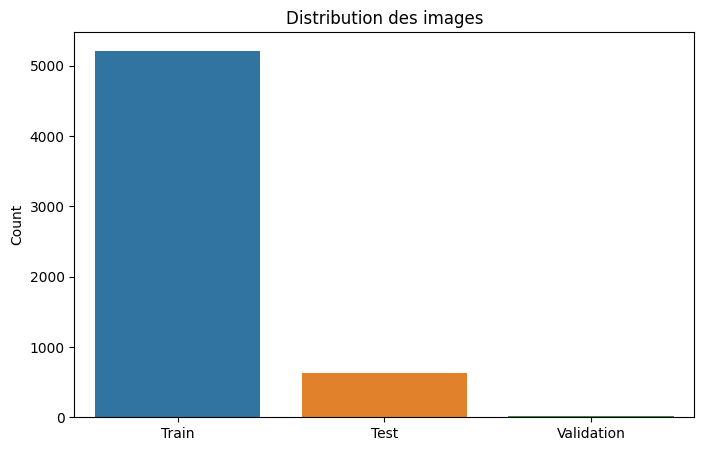

In [51]:
plt.figure(figsize=(8, 5))
sns.barplot(x=["Train", "Test", "Validation"], y=[train_normal + train_pneumonia, test_normal + test_pneumonia, validation_normal + validation_pneumonia])
plt.title("Distribution des images")
plt.ylabel("Count")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

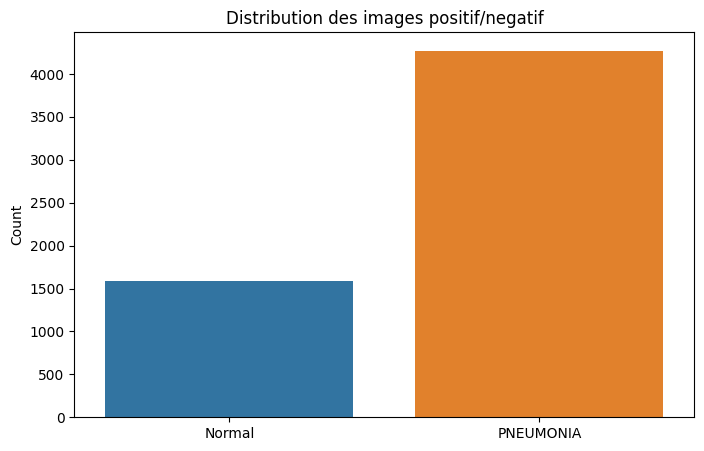

In [50]:
plt.figure(figsize=(8, 5))
sns.barplot(x=["Normal", "PNEUMONIA"], y=[train_normal + test_normal+ validation_normal, train_pneumonia + test_pneumonia + validation_pneumonia])
plt.title("Distribution des images positif/negatif")
plt.ylabel("Count")
plt.show

Nous constatons que le dataset est très désequilibré

# Construction du model CNN


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(image_size[0], image_size[1], 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Répétez les couches Conv2D et MaxPooling2D selon les besoins

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


#Entrainnement du model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # ou plus selon les besoins
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


# Evaluation du modèle

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples)
print('Test accuracy:', test_acc)


# Prédiction

In [ ]:
predictions = model.predict(test_generator, steps=test_generator.samples)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

result = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(result)


In [ ]:
# Visualisation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modèle Précision')
plt.ylabel('Précision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
# Sauvegarder le modèle
model.save('model1_pneumonia.h5')
